In [73]:
from scipy.stats import spearmanr
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

In [74]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Data Check

In [75]:
input_dir = '../Database/'
file_train = 'train.csv'
file_test = 'test.csv'
train = pd.read_csv(os.path.join(input_dir, file_train))
test = pd.read_csv(os.path.join(input_dir, file_test))

In [76]:
train['대출대비소득비율'] = np.where(train['연간소득'] == 0, 0, train['대출금액'] / train['연간소득'])
test['대출대비소득비율'] = np.where(test['연간소득'] == 0, 0, test['대출금액'] / test['연간소득'])

In [77]:
# train['이자대비원금'] = np.where(train['총상환원금'] == 0, 0, train['총상환이자'] / train['총상환원금'])
# test['이자대비원금'] = np.where(test['총상환원금'] == 0, 0, test['총상환이자'] / test['총상환원금'])

In [78]:
train['이자/대출'] = np.where(train['대출금액'] == 0, 0, train['총상환이자'] / train['대출금액'])
test['이자/대출'] = np.where(test['대출금액'] == 0, 0, test['총상환이자'] / test['대출금액'])

In [79]:
train['원금/대출'] = np.where(train['대출금액'] == 0, 0, train['총상환원금'] / train['대출금액'])
test['원금/대출'] = np.where(test['대출금액'] == 0, 0, test['총상환원금'] / test['대출금액'])

# Discretization

In [80]:
# 부채_대비_소득_비율, 총계좌수, 총연체금액, 연체계좌수, 최근_2년간_연체_횟수
Discretization = True

In [81]:
if Discretization:
    a_train = train['부채_대비_소득_비율']
    a_test = test['부채_대비_소득_비율']
    bins = [-1, 0, 20, 35, 50, 100, 10000]
    labels = [0, 1, 2, 3, 4, 5]
    a_train = pd.cut(a_train, bins=bins, labels=labels)
    a_test = pd.cut(a_test, bins=bins, labels=labels)

In [82]:
if Discretization:
    b_train = train['총계좌수']
    b_test = test['총계좌수']
    # b_train[b_train<7000]
    bins = [0, 15, 30, 40, 50, 70, 100, 170]
    labels = [0, 1, 2, 3, 4, 5, 6]
    b_train = pd.cut(b_train, bins=bins, labels=labels)
    b_test = pd.cut(b_test, bins=bins, labels=labels)

In [83]:
if Discretization:
    c_train = train['총연체금액']
    c_test = test['총연체금액']
    bins = [0, 100.0, 15000.0, 30000.0, 45000.0, 60000.0, 80000.0]
    labels = [0, 1, 2, 3, 4, 5]
    c_train = pd.cut(c_train, bins=bins, labels=labels)
    c_test = pd.cut(c_test, bins=bins, labels=labels)
    c_train = c_train.fillna(0)
    c_test = c_test.fillna(0)

In [84]:
train['부채_대비_소득_비율'] = a_train
train['총계좌수'] = b_train
train['총연체금액'] = c_train

test['부채_대비_소득_비율'] = a_test
test['총계좌수'] = b_test
test['총연체금액'] = c_test

In [85]:
# category_counts = train['대출등급'][b_train < 15].value_counts()
# 
# category_counts.plot(kind='bar')
# plt.xlabel('Category')
# plt.ylabel('Frequency')
# plt.title('Bar Chart of Categories')
# plt.show()

# Categorical Data Encoding

In [86]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출기간']))
train['대출기간'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출기간']))
test['대출기간'] = pd.DataFrame(encoder_data)

In [87]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['총계좌수']))
train['총계좌수'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['총계좌수']))
test['총계좌수'] = pd.DataFrame(encoder_data)

In [88]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['총연체금액']))
train['총연체금액'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['총연체금액']))
test['총연체금액'] = pd.DataFrame(encoder_data)

In [89]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['부채_대비_소득_비율']))
train['부채_대비_소득_비율'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['부채_대비_소득_비율']))
test['부채_대비_소득_비율'] = pd.DataFrame(encoder_data)

In [90]:
train['근로기간'] = train['근로기간'].str.extract(r'(\d+)')
train['근로기간'] = train['근로기간'].fillna(0)
train['근로기간'] = train['근로기간'].astype(int)

test['근로기간'] = test['근로기간'].str.extract(r'(\d+)')
test['근로기간'] = test['근로기간'].fillna(0)
test['근로기간'] = test['근로기간'].astype(int)

In [91]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['주택소유상태']))
train['주택소유상태'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['주택소유상태']))
test['주택소유상태'] = pd.DataFrame(encoder_data)

In [92]:
test.loc[34486, '대출목적'] = '기타'

In [93]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출목적']))
train['대출목적'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출목적']))
test['대출목적'] = pd.DataFrame(encoder_data)

In [94]:
train['연체계좌수'] = train['연체계좌수'].astype(int)
test['연체계좌수'] = test['연체계좌수'].astype(int)

In [95]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출등급']))
train['대출등급'] = pd.DataFrame(encoder_data)

# Data Scaling

In [96]:
train.set_index(train['ID'], inplace=True)
train.drop(columns='ID', inplace=True)

test.set_index(test['ID'], inplace=True)
test.drop(columns='ID', inplace=True)

In [97]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()

gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득','최근_2년간_연체_횟수', '총상환원금', '총상환이자', '이자/대출', '원금/대출', '대출대비소득비율']
X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)

data_scaled = scaler.fit_transform(X)
data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=train.index)

train.drop(columns=to_normalize_list, inplace=True)
train.drop(columns='대출등급', inplace=True)
train = pd.concat([gt, data_scaled, train], axis=1)

data_scaled = scaler.transform(Y)
data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=test.index)

test.drop(columns=to_normalize_list, inplace=True)
test = pd.concat([data_scaled, test], axis=1)

In [98]:
# gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
# to_normalize_list = ['대출금액', '연간소득', '최근_2년간_연체_횟수', '총상환원금', '총상환이자']
# 
# X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
# Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)
# 
# train.drop(columns=to_normalize_list, inplace=True)
# train.drop(columns='대출등급', inplace=True)
# test.drop(columns=to_normalize_list, inplace=True)
# 
# train = pd.concat([gt, X, train], axis=1)
# test = pd.concat([Y, test], axis=1)

# Outlier Handling

<Axes: >

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, '대출금액'),
  Text(2, 0, '연간소득'),
  Text(3, 0, '최근_2년간_연체_횟수'),
  Text(4, 0, '총상환원금'),
  Text(5, 0, '총상환이자'),
  Text(6, 0, '이자/대출'),
  Text(7, 0, '원금/대출'),
  Text(8, 0, '대출대비소득비율')])

Text(0.5, 0.98, 'Train Data')

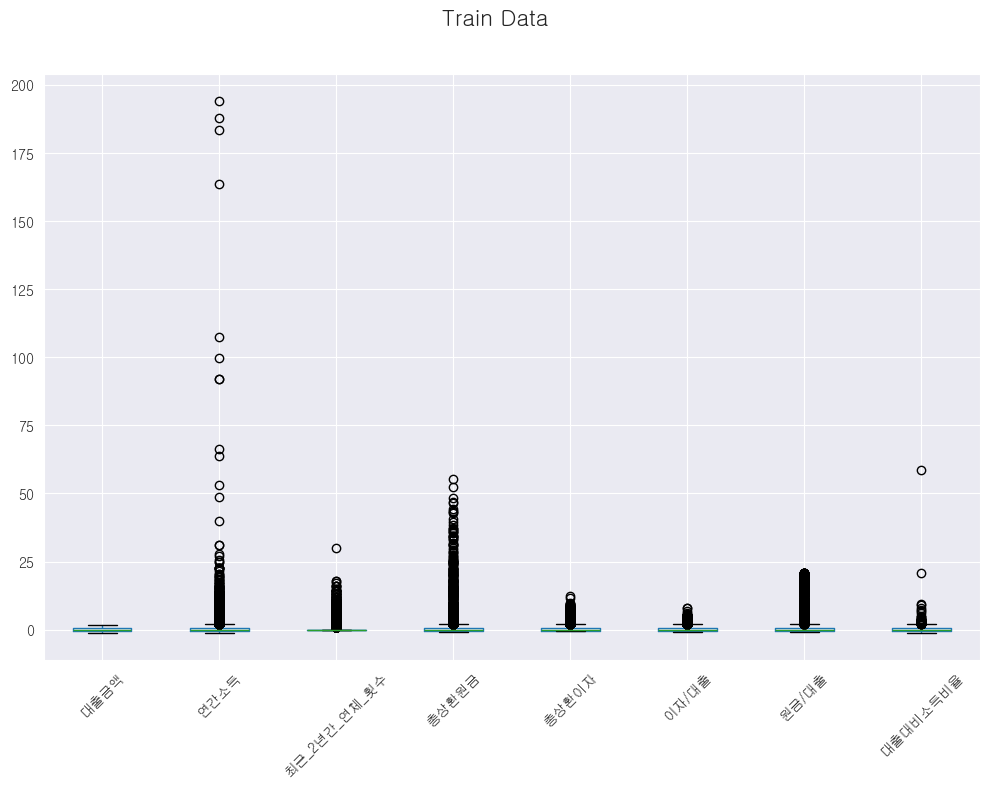

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))
train[to_normalize_list].boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [100]:
for col in to_normalize_list:
    train[col] = winsorize(train[col], limits=[0.0001, 0.0001])

<Axes: >

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, '대출금액'),
  Text(2, 0, '연간소득'),
  Text(3, 0, '최근_2년간_연체_횟수'),
  Text(4, 0, '총상환원금'),
  Text(5, 0, '총상환이자'),
  Text(6, 0, '이자/대출'),
  Text(7, 0, '원금/대출'),
  Text(8, 0, '대출대비소득비율')])

Text(0.5, 0.98, 'Train Data')

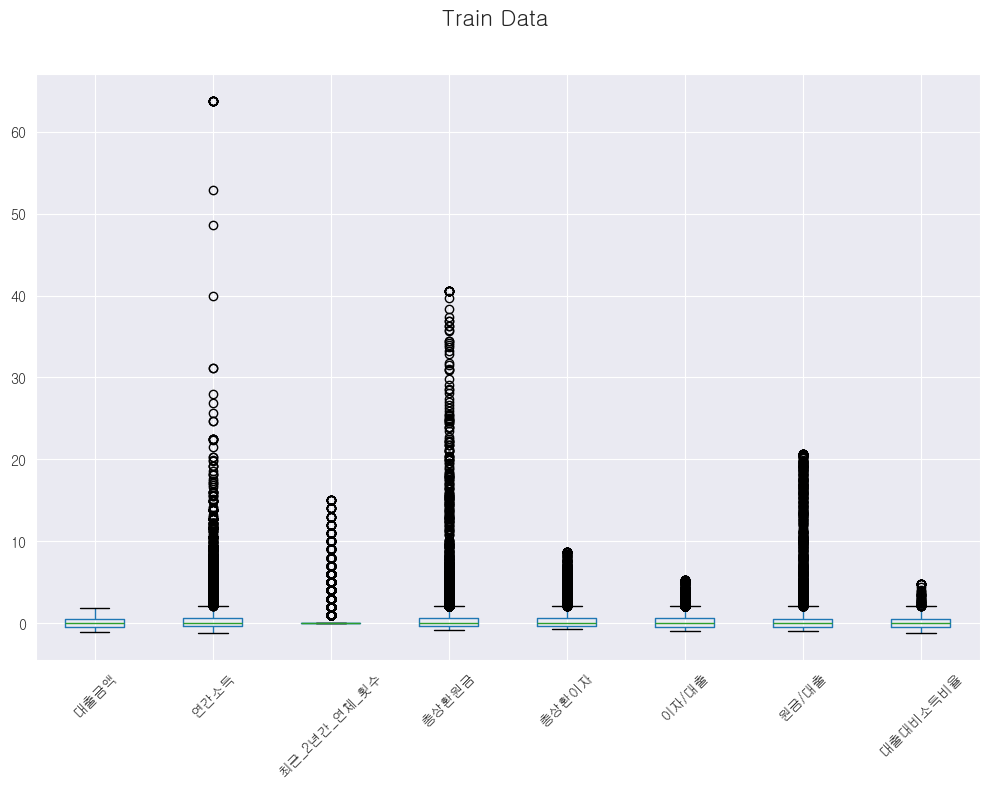

In [101]:
fig, ax = plt.subplots(figsize=(10, 8))
train[to_normalize_list].boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

# Feature Importance Checking by Random Forest

In [102]:
train.drop(columns=['최근_2년간_연체_횟수', '연체계좌수', '총연체금액', '부채_대비_소득_비율'], inplace=True)
test.drop(columns=['최근_2년간_연체_횟수', '연체계좌수', '총연체금액', '부채_대비_소득_비율'], inplace=True)

In [103]:
train_defg = train.loc[~train['대출등급'].isin([0,1,2])]
for i in range(4):
    condition = train_defg['대출등급'] == i + 3
    train_defg.loc[condition, '대출등급'] = i
train.loc[~train['대출등급'].isin([0,1,2]), '대출등급'] = 3

In [70]:
X = train.drop(columns=['대출등급'])
y = train['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [71]:
# class_counts = y_res.value_counts()
# plt.pie(class_counts, labels=class_counts.index, startangle=140, autopct='%1.1f%%')
# plt.axis('equal')
# plt.title('Class Distribution')
# plt.show()

In [72]:
params = {
    'n_estimators': 100,
    'criterion': 'entropy',
    'max_depth': 80,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'class_weight': 'balanced',
    'random_state': 42,
}

rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)
print("Random Forest Accuracy:", f1_score(y_test, rf_model.predict(X_test), average='macro'))

feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(
    'Importance', ascending=False)
print(feature_importances)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=80, min_samples_leaf=2, random_state=42)

Random Forest Accuracy: 0.921023900544413
          Importance
원금/대출       0.385583
이자/대출       0.251059
총상환원금       0.098520
총상환이자       0.096505
대출기간        0.055271
대출금액        0.042876
대출대비소득비율    0.033796
근로기간        0.011751
대출목적        0.010502
총계좌수        0.008159
주택소유상태      0.005978


# Select Features & Save Data

In [35]:
train.to_csv('../Database/train_abcd.csv')
test.to_csv('../Database/test_abcd.csv')
train_defg.to_csv('../Database/train_defg.csv')

# 카이제곱검정 & 다중공산성 & 상관계수

In [399]:
discrete_list = ['대출기간', '근로기간', '대출목적', '총계좌수', '주택소유상태']
continuous_list = [col for col in train.columns if col not in discrete_list]

for i in range(len(discrete_list)):
    contingency_table = pd.crosstab(train['대출등급'], train[discrete_list[i]])
    chi, p, dof, _ = chi2_contingency(contingency_table)
    print(f'{discrete_list[i]}: p_value = {p:.2f}, chi = {chi:.3f}, Degree Of Freedom = {dof}')

대출기간: p_value = 0.00, chi = 17338.803, Degree Of Freedom = 3
근로기간: p_value = 0.00, chi = 89.190, Degree Of Freedom = 30
대출목적: p_value = 0.00, chi = 5252.370, Degree Of Freedom = 33
총계좌수: p_value = 0.00, chi = 566.993, Degree Of Freedom = 18
주택소유상태: p_value = 0.00, chi = 655.138, Degree Of Freedom = 9


In [400]:
X = train[continuous_list]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

   Variable       VIF
0      대출등급  1.648399
1      대출금액  2.071636
2     총상환원금  1.611658
3     총상환이자  3.282595
4    이자대비원금  2.639833
5  대출대비소득비율  1.488482


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Heatmap')

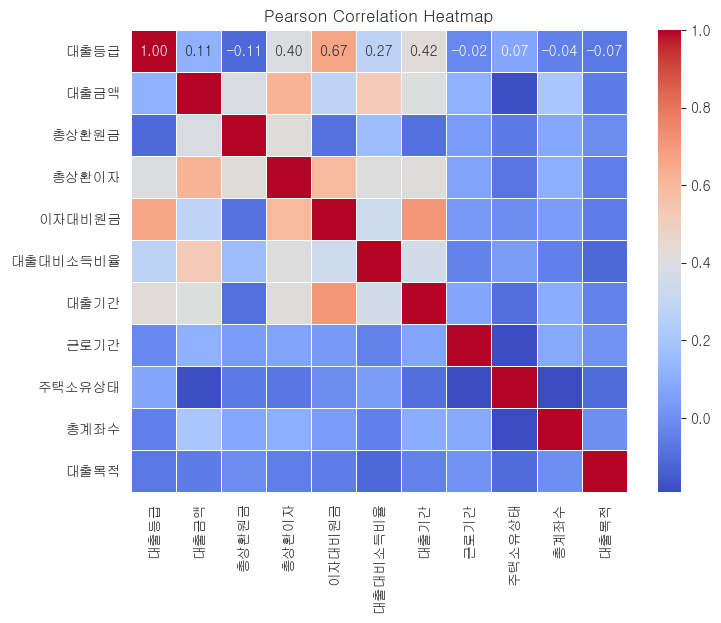

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Spearman Correlation Heatmap')

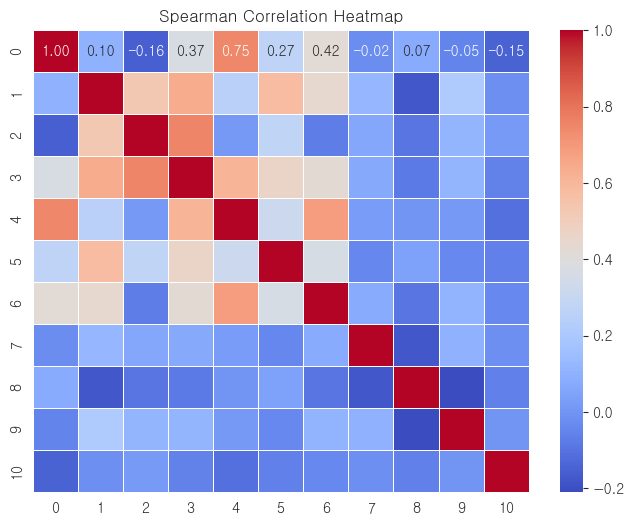

In [401]:
correlation_matrix = train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

correlation_matrix, _ = spearmanr(train)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()